### Installing and importing libraries

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks

import matplotlib.patches as mpatches
import time

In [8]:
%pip install scipy
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn
%pip install imbalanced-learn


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note

### STEP 2: Introducing and Loading the Dataset -- Esther

In [9]:
# Load in the dataset from a csv
csv = pd.read_csv('data/creditcard.csv')

# Convert the data to a pandas dataframe
cc_data = pd.DataFrame(csv)

# Get the shape of the dataframe: (rows, columns)
cc_data.shape

(284807, 31)

In [14]:
# See the first five rows of the dataframe:
cc_data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
239700,150222.0,2.158614,-1.803525,-0.003286,-1.556484,-1.979742,0.008234,-1.918838,0.182547,-0.702376,...,-0.105054,0.142136,0.280812,-0.381613,-0.566206,-0.245920,0.053671,-0.039783,40.55,0
22426,32242.0,1.121015,0.124176,0.249140,0.490708,-0.036220,0.169923,-0.240273,0.280300,-0.077971,...,-0.190457,-0.572238,0.187745,-0.355462,0.002463,0.139525,-0.000923,0.012003,3.99,0
244096,152201.0,2.031525,0.181196,-1.486995,0.526644,0.220660,-1.081224,0.196687,-0.256054,0.423170,...,-0.323069,-0.808706,0.406868,0.998801,-0.332918,0.144629,-0.057276,-0.025462,1.29,0
152521,97400.0,1.962449,-0.476774,0.260832,0.586674,-1.105115,-0.490299,-1.013983,-0.022098,2.771653,...,-0.119882,0.012813,0.335294,-0.005731,-0.648420,0.441823,-0.044522,-0.044336,15.95,0
207768,136829.0,2.046618,-0.003779,-1.080714,0.387270,0.011500,-1.060830,0.250213,-0.367437,0.381206,...,-0.271710,-0.603787,0.319586,-0.054004,-0.270041,0.201133,-0.061850,-0.057768,8.30,0


### STEP 3: Exploratory data analysis -- Ria

In [17]:
# See how much of our original data was fraudulent, etc.
print('No Frauds', round(cc_data['Class'].value_counts()[0]/len(cc_data) * 100,2), '% of the dataset')
print('Frauds', round(cc_data['Class'].value_counts()[1]/len(cc_data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [18]:
fraud_cc_data = cc_data.loc[cc_data['Class'] == 1]
non_fraud_cc_data = cc_data.loc[cc_data['Class'] == 0][:492]
display(fraud_cc_data.head())
display(non_fraud_cc_data.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


/var/folders/mk/fsy7_c3n2wz82_zjfzvtfdcw0000gn/T/ipykernel_78186/55826972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cc_data, x='Class', palette=colors)


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

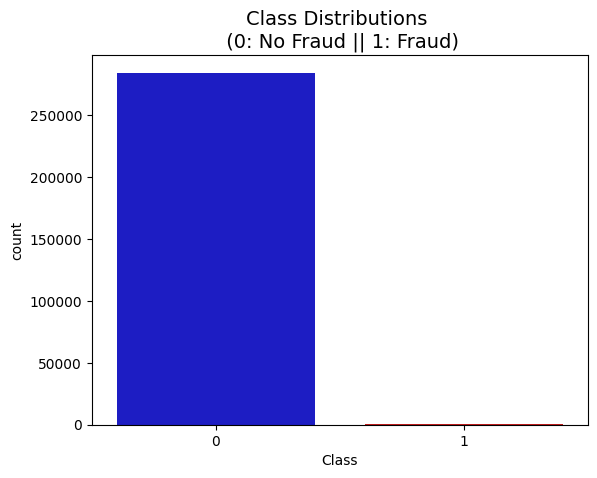

In [21]:
colors = ["#0101DF", "#DF0101"]

# Create a bar chart that visualizes the imbalance between fraudulent and non-fraudulent data
sns.countplot(data=cc_data, x='Class', palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [24]:
""" 
Check for missing data.
This is important because we want to make sure that our data is clean before moving forward.
"""
print("Missing data in each column:\n" + str(cc_data.isnull().sum()))

Missing data in each column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


### Spam and Ham Stuff


In [26]:
cc_data['target'].value_counts()

KeyError: 'target'

In [27]:
# Explore distribution of dataset 

# count plot on single categorical variable
ax = sns.countplot(x = data['classification'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

NameError: name 'data' is not defined

Note: Distribution of dataset indicates imbalanced data.

In [14]:
# Dropping all duplicate texts based off of results of EDA
df_no_dup = data.drop_duplicates(subset=['text'], keep='first')

/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


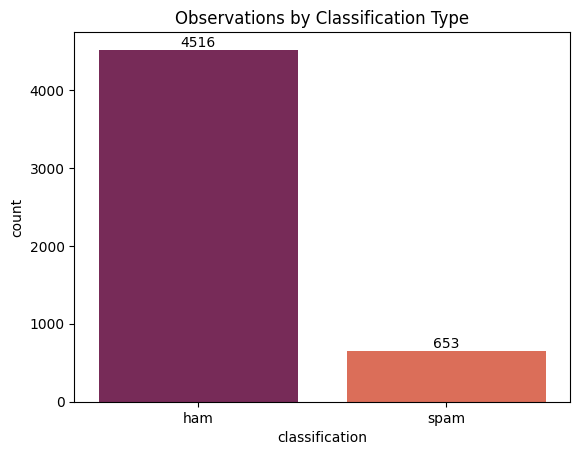

In [15]:
# Explore distribution of dataset 

# count plot on single categorical variable
ax = sns.countplot(x = df_no_dup['classification'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

## STEP 4: Initializing a Baseline Model with sklearn (no undersampling) -- MILLER

NOTE: idt we need this data splitting, just initialize a baseline model with no undersampling.

STEAL FROM OVERSAMPLING FOR THIS!

Choose what features we should build the rest of our model on.


### WE'RE USING RANDOM FORESTS AS OUR CLASSIFIER

In [28]:
# We want two variables we can visualize in a plot.
# The two columns we will get are 
# um
# personally V1 and V4 stick out to me so i'm gonna plot these, feel free to play around

# Split into input, features_trained_on, and output, output_feature
features_trained_on = cc_data.iloc[:, [1, 4]]

output_feature = cc_data.iloc[:, -1]

(284807, 2)


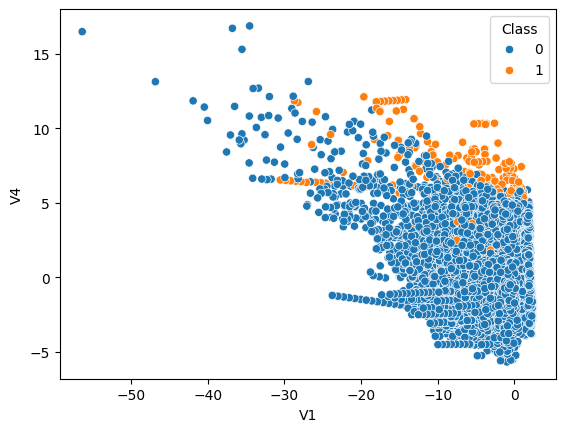

In [30]:
# plot these on a scatter plot to see how they differ between the two classes
ax = sns.scatterplot(data=cc_data, x='V1', y='V4', hue='Class')
plt.show()

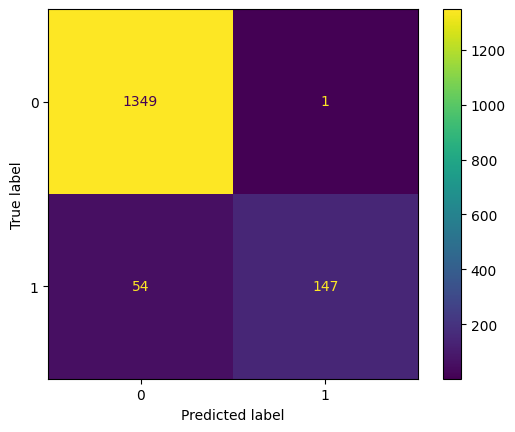

In [132]:
#compute the confusion matrix.
cm = confusion_matrix(Y_test, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## STEP 4b: Evaluation with Performance Metrics -- Alyssa

In this naive implementation of our model, using no aspect of downsampling to modify and clean our data, we get this for our accuracy:

## STEP 5: Undersampling Techniques -- Esther (just write the general blurb for this)

### Random Undersampling -- Esther

### Random Under-Sampling

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(data=df, x='Class', palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [11]:
print('Top 5 common duplicate texts are:')
data[data.duplicates == 1].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

Top 5 common duplicate texts are:


,target
text,
"Sorry, I'll call later",30
I cant pick the phone right now. Pls send a message,12
Ok...,10
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4


###  Near Miss Undersampling -- Ria

### Tomek Link Undersampling -- Miller